In [1]:
# pip install pyannote.audio

In [2]:
from pyannote.audio import Pipeline
from pydub import AudioSegment
import os

/home/mincong2/.local/lib/python3.12/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [14]:
audio_file = "Pyannote/Test_data/test_1.wav"
pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token="hf...")

In [15]:
import torch
pipeline.to(torch.device("cuda"))

In [21]:
diarization = pipeline(audio_file, num_speakers=2)

for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"{turn.start:.2f}s ~ {turn.end:.2f}s: {speaker}")

4.81s ~ 7.19s: SPEAKER_01
5.33s ~ 6.93s: SPEAKER_00
8.72s ~ 12.37s: SPEAKER_01
8.84s ~ 9.43s: SPEAKER_00
13.06s ~ 14.34s: SPEAKER_01
14.88s ~ 16.21s: SPEAKER_01
17.01s ~ 17.73s: SPEAKER_01
18.95s ~ 21.51s: SPEAKER_01
22.17s ~ 22.59s: SPEAKER_01
23.05s ~ 24.13s: SPEAKER_01
25.36s ~ 25.98s: SPEAKER_01
26.63s ~ 29.14s: SPEAKER_01
26.71s ~ 27.45s: SPEAKER_00
29.87s ~ 30.42s: SPEAKER_01
31.23s ~ 31.84s: SPEAKER_01
32.25s ~ 34.51s: SPEAKER_01
35.89s ~ 37.75s: SPEAKER_00
37.75s ~ 38.00s: SPEAKER_01
38.42s ~ 39.79s: SPEAKER_01
41.26s ~ 41.41s: SPEAKER_00
41.41s ~ 42.78s: SPEAKER_01
44.04s ~ 44.99s: SPEAKER_01
45.59s ~ 47.06s: SPEAKER_01
47.50s ~ 48.48s: SPEAKER_01
47.70s ~ 48.61s: SPEAKER_00
48.61s ~ 49.51s: SPEAKER_01
49.98s ~ 52.63s: SPEAKER_01
50.08s ~ 52.33s: SPEAKER_00
52.83s ~ 53.27s: SPEAKER_01


In [20]:
audio = AudioSegment.from_file(audio_file)

output_dir = os.path.join("Pyannote", "speaker_segments")
os.makedirs(output_dir, exist_ok=True)

speaker_segments = {} 
for turn, _, speaker in diarization.itertracks(yield_label=True):
    if speaker not in speaker_segments:
        speaker_segments[speaker] = []
    speaker_segments[speaker].append((turn.start, turn.end))

for speaker, segments in speaker_segments.items():
    for idx, (start, end) in enumerate(segments):
        #밀리초단위여서
        segment = audio[int(start * 1000):int(end * 1000)]
        filename = f"{output_dir}/{speaker}_{idx}.wav"
        segment.export(filename, format="wav")
        print(f"Saved: {filename}")

Saved: Pyannote/speaker_segments/SPEAKER_01_0.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_1.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_2.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_3.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_4.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_5.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_6.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_7.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_8.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_9.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_10.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_11.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_12.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_13.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_14.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_15.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_16.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_17.wav
Saved: Pyannote/speaker_segments/SPEAKER_01_18.wav
Saved: Pyannote/speaker_segments/SPEAKER_

In [ ]:
# 겹치는 구간 확인

In [22]:
segments = []
for turn, _, speaker in diarization.itertracks(yield_label=True):
    segments.append({"start": turn.start, "end": turn.end, "speaker": speaker})

overlaps = []
for i in range(len(segments)):
    for j in range(i+1, len(segments)):
        s1 = segments[i]
        s2 = segments[j]
        if s1['speaker'] != s2['speaker']:
            latest_start = max(s1['start'], s2['start'])
            earliest_end = min(s1['end'], s2['end'])
            if latest_start < earliest_end: 
                overlaps.append({
                    "start": latest_start,
                    "end": earliest_end,
                    "speakers": (s1['speaker'], s2['speaker'])
                })

print("Overlapping segments:")
for o in overlaps:
    print(f"{o['start']:.2f}s ~ {o['end']:.2f}s: {o['speakers']}")

Overlapping segments:
5.33s ~ 6.93s: ('SPEAKER_01', 'SPEAKER_00')
8.84s ~ 9.43s: ('SPEAKER_01', 'SPEAKER_00')
26.71s ~ 27.45s: ('SPEAKER_01', 'SPEAKER_00')
47.70s ~ 48.48s: ('SPEAKER_01', 'SPEAKER_00')
50.08s ~ 52.33s: ('SPEAKER_01', 'SPEAKER_00')


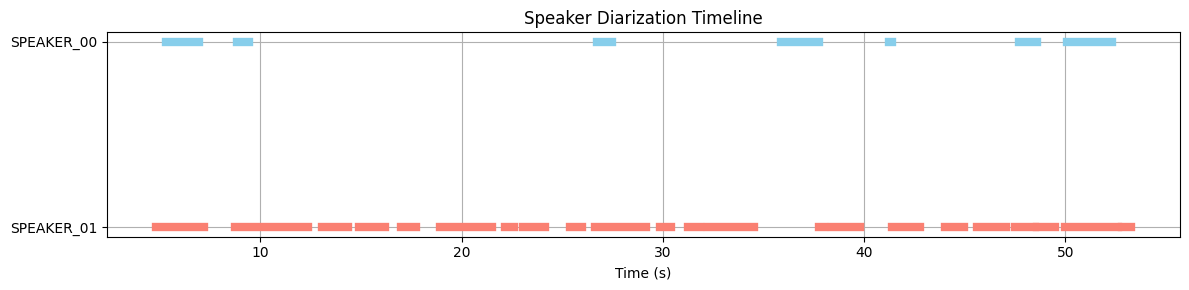

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 3))
colors = {"SPEAKER_00": "skyblue", "SPEAKER_01": "salmon"}

for segment in segments:
    ax.plot([segment["start"], segment["end"]], 
            [segment["speaker"], segment["speaker"]],
            color=colors[segment["speaker"]], linewidth=6)

ax.set_yticks(["SPEAKER_00", "SPEAKER_01"])
ax.set_xlabel("Time (s)")
ax.set_title("Speaker Diarization Timeline")
plt.grid(True)
plt.tight_layout()
plt.show()